#### (Hardikkumar M. Dhaduk)

# Autoencoder assignment

Autoencoders are part of neural network family. The algorithm is fairly simple as Autoencoders require output to be the same as input. The Autoencoders compress input data to latent-space representation and then reconstruct the output. In this assignment algorithm divide into two subsets:

**Encoder** – compressing the input data to lower dimensional representation sometimes called bottleneck or latent-space representation.

**Decoder** – decompressing the representation to reconstruct the input as best as possible.

![](https://firebasestorage.googleapis.com/v0/b/python-assignments-hardikkumar.appspot.com/o/encoder-decoder-768x336.png?alt=media&token=3afceaa1-d6f6-49e8-8b3f-7de4a62c6398)

# Data Loading and Preprocessing

For this assignment, I'm going to use the [MNIST data set](http://yann.lecun.com/exdb/mnist/).

In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

Using TensorFlow backend.


Keras `load_data` function will download the data directly from S3 on AWS.

In [2]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

# Scales the training and test data.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

handwritten digits

![](https://firebasestorage.googleapis.com/v0/b/python-assignments-hardikkumar.appspot.com/o/mnist.png?alt=media&token=6384db17-8c77-48bf-a064-61a9e9b00459)

The data set consists 3D arrays with 60K training and 10K test images. The images have a resolution of 28 x 28 (pixels).

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

To work with the images as vectors, reshape the 3D arrays as matrices. In doing so, Reshape the 28 x 28 images into vectors of length 784

In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

***

# Denoising Autoencoder

While the main purpose of basic Autoencoder is to compress and reduce dimensionality of data, Denoising Autoencoder are used in another practical application. Imagine a set of low quality images with some noise. Is it possible to clear these images from noise using machine learning algorithms? YES!.

Denoising Autoencoder used forclear handwritten MNIST digits from **Gaussian random noise**.
 
![](https://firebasestorage.googleapis.com/v0/b/python-assignments-hardikkumar.appspot.com/o/noisy_digits-768x155.png?alt=media&token=f8af0a77-e6b2-486e-9a48-c7f0041494a4) 

***

# Convolutional Neural Networks

The main limitation of standard neural networks with fully connected layers is the fact that they do not scale well for images. An input image represented by 512×512 matrix used with 1000 neurons in the first fully-connected layer requires 512*512*1000 = 262 144 000 weights to be optimized. Adding subsequent layers increases this enormous number even more. Obviously, it can quickly lead to overfitting. The solution to this problem is to decrease the size of an input in wise way. Convolutional Neural Networks (CNN) are used explicitly in the cases when input is an image. They use additional layers at the beginning of the neural network to reduce the size and preprocess an image.

The basic architecture of CNN:

**Convolutional Layer** – uses convolutional operator to filter input signal and extract some additional image features,

**Activation Function** – applies non-linear function such as rectifier to the outputs of convolutional layer,

**Pooling Layer** – performs a downsampling operation reducing the size of an input with max() or sum() operation,

**Fully-Connected Layer** – each neuron in the previous layer is connected to each neuron on the next layer with last such layer producing outputs of neural network.

![](https://firebasestorage.googleapis.com/v0/b/python-assignments-hardikkumar.appspot.com/o/cnn-1-768x315.png?alt=media&token=7e068632-dde1-4cef-b62b-023d04626d0a)

In other words convolutional and pooling layers represent high-level features of the input image. The pooling layer reduces the size of an image to control overfitting. Moreover, convolutional and pooling layers are still valid to use during backpropagation algorithm so that the neural network can be still trained using gradient descent approaches.

***


# Convolutional Denoising Autoencoder

Using Keras encoding and decoding very easy. Reshapes the images back to `28 x 28 x 1` for the convnets. The 1 is for 1 channel because black and white. If RGB color, there would be 3 channels.

In [5]:
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

To build the convolutional autoencoder, we'll make use of `Conv2D` and `MaxPooling2D` layers for the encoder and `Conv2D` and `UpSampling2D` layers for the decoder. The encoded images are transformed to a 3D array of dimensions `4 x 4 x 8`, but to visualize the encoding, we'll flatten it to a vector of length 128. In this assignment I tried to use an encoding dimension of 32 like above.

After the flattening layer, I reshape the image back to a `4 x 4 x 8` array before upsampling back to a `28 x 28 x 1` image.

In [6]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)          

## Encoder Model

In [8]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0   

In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist_1 = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 176us/step - loss: 0.1401 - acc: 0.8024 - val_loss: 0.1239 - val_acc: 0.8060
Epoch 2/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.1176 - acc: 0.8085 - val_loss: 0.1105 - val_acc: 0.8093
Epoch 3/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.1083 - acc: 0.8105 - val_loss: 0.1041 - val_acc: 0.8102
Epoch 4/100
60000/60000 [==============================] - 10s 167us/step - loss: 0.1030 - acc: 0.8115 - val_loss: 0.0996 - val_acc: 0.8114
Epoch 5/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.0994 - acc: 0.8121 - val_loss: 0.0967 - val_acc: 0.8113
Epoch 6/100
60000/60000 [==============================] - 10s 165us/step - loss: 0.0969 - acc: 0.8126 - val_loss: 0.0950 - val_acc: 0.8116
Epoch 7/100
60000/60000 [==============================] - 10s 165us/step - loss: 0.0951 - acc: 0.8129 - val_l

Epoch 59/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.0805 - acc: 0.8147 - val_loss: 0.0794 - val_acc: 0.8138
Epoch 60/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.0805 - acc: 0.8147 - val_loss: 0.0794 - val_acc: 0.8138
Epoch 61/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.0804 - acc: 0.8147 - val_loss: 0.0794 - val_acc: 0.8138
Epoch 62/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.0804 - acc: 0.8147 - val_loss: 0.0794 - val_acc: 0.8137
Epoch 63/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.0804 - acc: 0.8147 - val_loss: 0.0794 - val_acc: 0.8137
Epoch 64/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.0803 - acc: 0.8147 - val_loss: 0.0792 - val_acc: 0.8138
Epoch 65/100
60000/60000 [==============================] - 10s 174us/step - loss: 0.0803 - acc: 0.8147 - val_loss: 0.0794 - val_acc: 0.8137
Epoch 66/100


Accuracy: 0.8141839
Loss: 0.08406566240576901


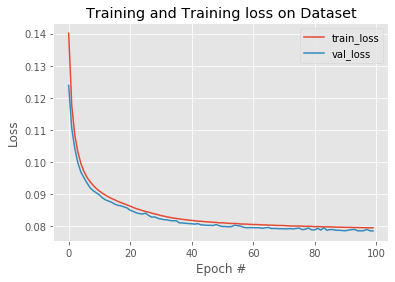

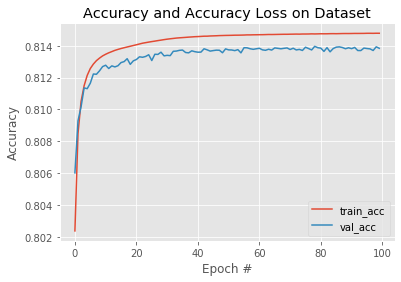

In [14]:
# plot the training and training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), hist_1.history["loss"], label=r"train_loss")
plt.plot(np.arange(0, 100), hist_1.history["val_loss"], label=r"val_loss")
plt.title("Training and Training loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Training Plot.png")

# plot the accuracy and accuracy loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), hist_1.history["acc"], label=r"train_acc")
plt.plot(np.arange(0, 100), hist_1.history["val_acc"], label=r"val_acc")
plt.title("Accuracy and Accuracy Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy Plot.png")
print('Accuracy:', np.mean(hist_1.history['acc']))
print('Loss:', np.mean(hist_1.history['loss']))

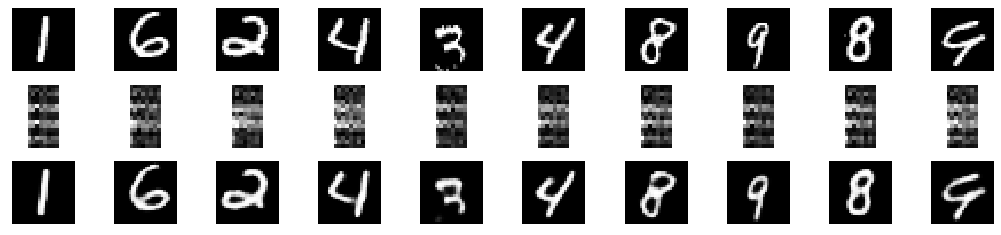

In [15]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Images with the Convolutional Autoencoder

Add bit of noise to the test images and see how good the convolutional autoencoder is at removing the noise.

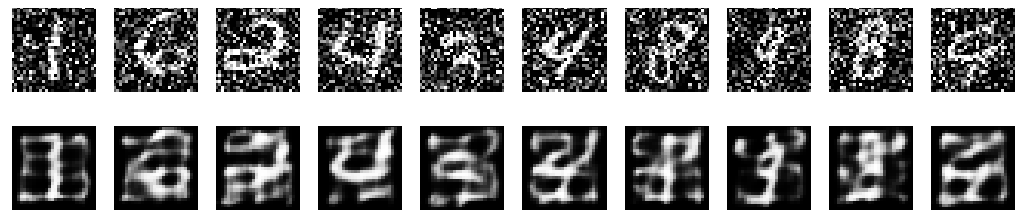

In [16]:
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Autoencoder

Those images are terrible. So, Now use `(x_train_noisy, x_train)` as training data and `(x_test_noisy, x_test)` as validation data.

In [17]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)       

In [19]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist_2 = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 17s 286us/step - loss: 0.1276 - acc: 0.8085 - val_loss: 0.1119 - val_acc: 0.8110
Epoch 2/100
60000/60000 [==============================] - 16s 268us/step - loss: 0.1095 - acc: 0.8118 - val_loss: 0.1061 - val_acc: 0.8106
Epoch 3/100
60000/60000 [==============================] - 16s 269us/step - loss: 0.1055 - acc: 0.8123 - val_loss: 0.1045 - val_acc: 0.8123
Epoch 4/100
60000/60000 [==============================] - 16s 269us/step - loss: 0.1034 - acc: 0.8126 - val_loss: 0.1017 - val_acc: 0.8115
Epoch 5/100
60000/60000 [==============================] - 16s 269us/step - loss: 0.1019 - acc: 0.8128 - val_loss: 0.1002 - val_acc: 0.8118
Epoch 6/100
60000/60000 [==============================] - 16s 269us/step - loss: 0.1008 - acc: 0.8129 - val_loss: 0.0994 - val_acc: 0.8123
Epoch 7/100
60000/60000 [==============================] - 17s 283us/step - loss: 0.1000 - acc: 0.8130 - val_l

Epoch 59/100
60000/60000 [==============================] - 16s 272us/step - loss: 0.0938 - acc: 0.8137 - val_loss: 0.0935 - val_acc: 0.8127
Epoch 60/100
60000/60000 [==============================] - 16s 266us/step - loss: 0.0938 - acc: 0.8137 - val_loss: 0.0935 - val_acc: 0.8128
Epoch 61/100
60000/60000 [==============================] - 22s 371us/step - loss: 0.0938 - acc: 0.8137 - val_loss: 0.0936 - val_acc: 0.8125
Epoch 62/100
60000/60000 [==============================] - 26s 440us/step - loss: 0.0938 - acc: 0.8137 - val_loss: 0.0934 - val_acc: 0.8127
Epoch 63/100
60000/60000 [==============================] - 27s 456us/step - loss: 0.0938 - acc: 0.8137 - val_loss: 0.0935 - val_acc: 0.8127
Epoch 64/100
60000/60000 [==============================] - 27s 454us/step - loss: 0.0937 - acc: 0.8137 - val_loss: 0.0934 - val_acc: 0.8128
Epoch 65/100
60000/60000 [==============================] - 17s 278us/step - loss: 0.0937 - acc: 0.8137 - val_loss: 0.0935 - val_acc: 0.8126
Epoch 66/100


Accuracy: 0.8135107
Loss: 0.09530221740233898


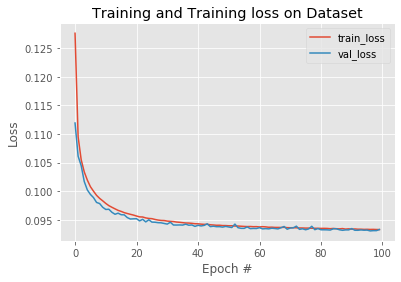

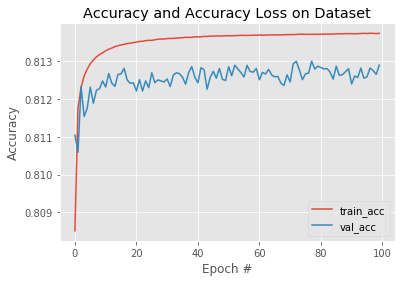

In [20]:
# plot the training and training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), hist_2.history["loss"], label=r"train_loss")
plt.plot(np.arange(0, 100), hist_2.history["val_loss"], label=r"val_loss")
plt.title("Training and Training loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Training Plot.png")

# plot the accuracy and accuracy loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), hist_2.history["acc"], label=r"train_acc")
plt.plot(np.arange(0, 100), hist_2.history["val_acc"], label=r"val_acc")
plt.title("Accuracy and Accuracy Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy Plot.png")
print('Accuracy:', np.mean(hist_2.history['acc']))
print('Loss:', np.mean(hist_2.history['loss']))

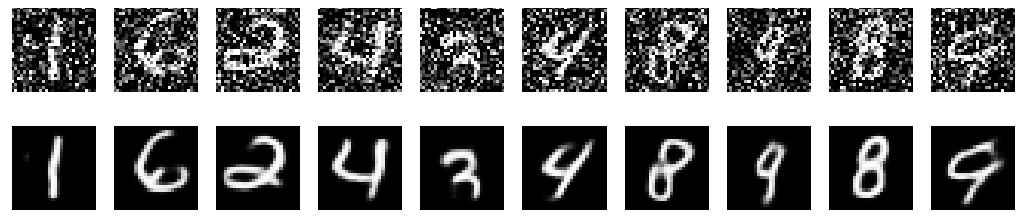

In [21]:
# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

So, basically this model have **81% accuracy**. From the above images observation this model did a good job in denoising the noisy images and it's almost look like the originals using CNN. 